# Sensitivity to ISO

In [1]:
using ModelingToolkit
using OrdinaryDiffEq
using SteadyStateDiffEq
using Plots
using LsqFit
using CaMKIIModel
using CaMKIIModel: μM, hil, Hz, hilr, second
Plots.default(lw=1.5)

## Setup b1AR system

In [2]:
@parameters ATP = 5000μM ISO = 0μM
sys = get_bar_sys(ATP, ISO; simplify=true)

Model bar_sys:
Equations (27):
  27 standard: see equations(bar_sys)
Unknowns (27): see unknowns(bar_sys)
  LR(t) [defaults to 6.0e-5]
  LRG(t) [defaults to 0.00294]
  RG(t) [defaults to 7.0e-5]
  GsaGTP(t) [defaults to 0.05214]
  ⋮
Parameters (94): see parameters(bar_sys)
  kr_AC_Gsa [defaults to 0.4]
  k_PKA_LCC [defaults to 0.054]
  kcat_pp2a_RyR [defaults to 0.0101]
  kf_bARK [defaults to 1.1e-6]
  ⋮
Observed (26): see observed(bar_sys)

In [3]:
prob = SteadyStateProblem(sys, [])
alg = DynamicSS(Rodas5P())

SteadyStateDiffEq.DynamicSS{OrdinaryDiffEqRosenbrock.Rodas5P{0, ADTypes.AutoForwardDiff{nothing, Nothing}, Nothing, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}, Float64}(OrdinaryDiffEqRosenbrock.Rodas5P{0, ADTypes.AutoForwardDiff{nothing, Nothing}, Nothing, typeof(OrdinaryDiffEqCore.DEFAULT_PRECS), Val{:forward}(), true, nothing, typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!)}(nothing, OrdinaryDiffEqCore.DEFAULT_PRECS, OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, ADTypes.AutoForwardDiff()), Inf)

Log scale for ISO concentration

In [4]:
iso = logrange(1e-4μM, 1μM, length=1001)

1001-element Base.LogRange{Float64, Base.TwicePrecision{Float64}}:
 0.0001, 0.000100925, 0.000101859 … 0.972747, 0.981748, 0.990832, 1.0

In [5]:
prob_func = (prob, i, repeat) -> remake(prob, p=[ISO => iso[i]])
trajectories = length(iso)
sol = solve(prob, alg; abstol=1e-10, reltol=1e-10) ## warmup
sim = solve(EnsembleProblem(prob; prob_func, safetycopy=false), alg; trajectories, abstol=1e-10, reltol=1e-10)

EnsembleSolution Solution of length 1001 with uType:
SciMLBase.NonlinearSolution{Float64, 1, Vector{Float64}, Vector{Float64}, SciMLBase.SteadyStateProblem{Vector{Float64}, true, ModelingToolkit.MTKParameters{Vector{Float64}, Tuple{}, Tuple{}, Tuple{}, Tuple{}}, SciMLBase.ODEFunction{true, SciMLBase.AutoSpecialize, ModelingToolkit.var"#f#1023"{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0x09431187, 0x84cca6a7, 0x97413d2f, 0x7a2f8ed7, 0x776a952e), Nothing}, RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :ˍ₋arg1, :ˍ₋arg2, :t), ModelingToolkit.var"#_RGF_ModTag", ModelingToolkit.var"#_RGF_ModTag", (0xc3739b69, 0x256ed108, 0x0bea72c4, 0xe929c8f5, 0xba487052), Nothing}}, LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, ModelingToolkit.ObservedFunctionCache{ModelingToolkit.ODESystem}, Nothing, M

In [6]:
"""Extract values from ensemble simulations by a symbol"""
extract(sim, k) = map(s -> s[k], sim)
"""Calculate Root Mean Square Error (RMSE)"""
rmse(fit) = sqrt(sum(abs2, fit.resid) / length(fit.resid))

Main.var"##230".rmse

In [7]:
xopts = (xlims=(iso[begin], iso[end]), minorgrid=true, xscale=:log10, xlabel="ISO (μM)",)
plot(iso, extract(sim, sys.cAMP); lab="cAMP", ylabel="Conc. (μM)", legend=:topleft, xopts...)

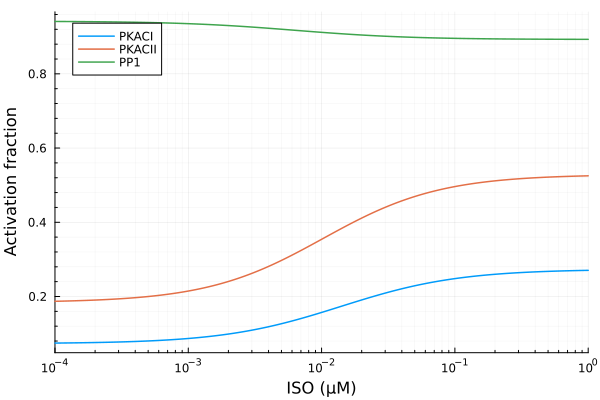

In [8]:
plot(iso, extract(sim, sys.PKACI / sys.RItot); lab="PKACI", ylabel="Activation fraction")
plot!(iso, extract(sim, sys.PKACII / sys.RIItot), lab="PKACII")
plot!(iso, extract(sim, sys.PP1 / sys.PP1totBA), lab="PP1", legend=:topleft; xopts...)

## Fitting active PKACI

In [9]:
@. model(x, p) = p[1] * x / (x + p[2]) + p[3]
xdata = iso
ydata = extract(sim, sys.PKACI / sys.RItot)
p0 = [0.3, 0.01μM, 0.08]
lb = [0.0, 0.0, 0.0]
pkac1_fit = curve_fit(model, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pkac1_coef = coef(pkac1_fit)

3-element Vector{Float64}:
 0.19937291922587674
 0.01390618008652709
 0.07340272516422842

In [10]:
println("PKACI")
println("Basal activity: ", pkac1_coef[3])
println("Activated activity: ", pkac1_coef[1])
println("Michaelis constant: ", pkac1_coef[2], " μM")
println("RMSE: ", rmse(pkac1_fit))

PKACI
Basal activity: 0.07340272516422842
Activated activity: 0.19937291922587674
Michaelis constant: 0.01390618008652709 μM
RMSE: 0.00032692395161732987


In [11]:
ypred = model.(xdata, Ref(pkac1_coef))
p1 = plot(xdata, [ydata ypred], lab=["Full model" "Fitted"], line=[:dash :dot], title="PKACI", legend=:topleft; xopts...)
p2 = plot(xdata, (ypred .- ydata) ./ ydata .* 100; title="PKACI error (%)", lab=false, xopts...)
plot(p1, p2, layout=(2, 1), size=(600, 600))

## Fitting active PKACII

In [12]:
xdata = iso
ydata = extract(sim, sys.PKACII / sys.RIItot)
p0 = [0.4, 0.01μM, 0.2]
lb = [0.0, 0.0, 0.0]
pkac2_fit = curve_fit(model, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pkac2_coef = coef(pkac2_fit)

3-element Vector{Float64}:
 0.34437074646162363
 0.0102510292463815
 0.18399257666411384

In [13]:
println("PKACII")
println("Basal activity: ", pkac2_coef[3])
println("Activated activity: ", pkac2_coef[1])
println("Michaelis constant: ", pkac2_coef[2], " μM")
println("RMSE: ", rmse(pkac2_fit))

PKACII
Basal activity: 0.18399257666411384
Activated activity: 0.34437074646162363
Michaelis constant: 0.0102510292463815 μM
RMSE: 0.00024370436419444156


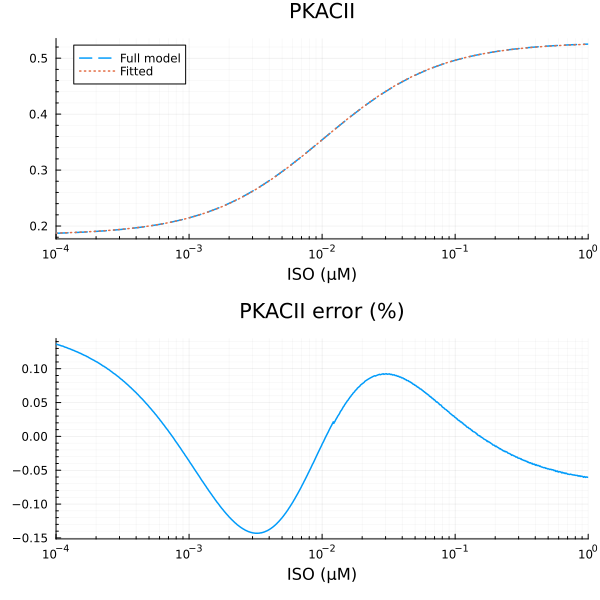

In [14]:
ypred = model.(xdata, Ref(pkac2_coef))
p1 = plot(xdata, [ydata ypred], lab=["Full model" "Fitted"], line=[:dash :dot], title="PKACII", legend=:topleft; xopts...)
p2 = plot(xdata, (ypred .- ydata) ./ ydata .* 100; title="PKACII error (%)", lab=false, xopts...)
plot(p1, p2, layout=(2, 1), size=(600, 600))

## Least-square fitting of PP1 activity

In [15]:
@. model_pp1(x, p) = p[1] * p[2] / (x + p[2]) + p[3]
xdata = iso
ydata = extract(sim, sys.PP1 / sys.PP1totBA)
p0 = [0.1, 3e-3μM, 0.8]
lb = [0.0, 0.0, 0.0]
pp1_fit = curve_fit(model_pp1, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pp1_coef = coef(pp1_fit)

3-element Vector{Float64}:
 0.049191945661098316
 0.00636190136348291
 0.8927131197462342

In [16]:
println("PP1")
println("Repressible activity: ", pp1_coef[1])
println("Minimal activity: ", pp1_coef[3])
println("Repressive Michaelis constant: ", pp1_coef[2], " μM")
println("RMSE: ", rmse(pp1_fit))

PP1
Repressible activity: 0.049191945661098316
Minimal activity: 0.8927131197462342
Repressive Michaelis constant: 0.00636190136348291 μM
RMSE: 3.5404825206962226e-5


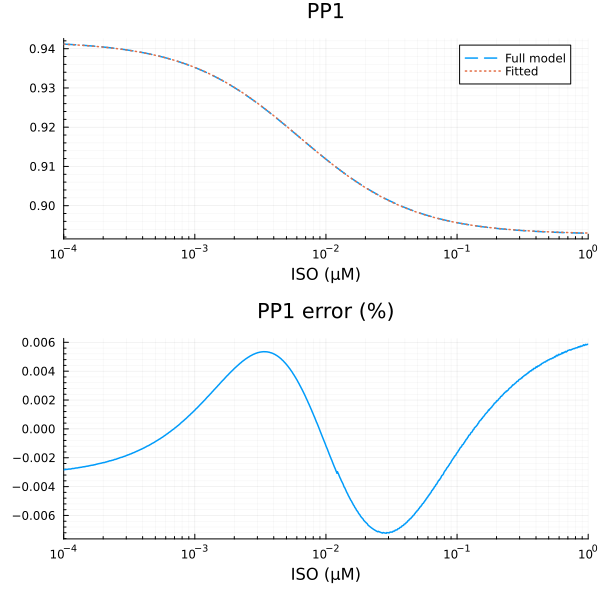

In [17]:
ypred = model_pp1.(xdata, Ref(pp1_coef))
p1 = plot(xdata, [ydata ypred], lab=["Full model" "Fitted"], line=[:dash :dot], title="PP1", legend=:topright; xopts...)
p2 = plot(xdata, (ypred .- ydata) ./ ydata .* 100; title="PP1 error (%)", lab=false, xopts...)
plot(p1, p2, layout=(2, 1), size=(600, 600))

## Fitting PLBp

In [18]:
xdata = iso
ydata = extract(sim, sys.PLBp / sys.PLBtotBA)
plot(xdata, ydata, title="PLBp fraction", lab=false; xopts...)

First try: Hill function

In [19]:
@. model_plb(x, p) = p[1] * hil(x, p[2], p[3]) + p[4]
p0 = [0.8, 1e-2μM, 1.0, 0.1]
lb = [0.5, 1e-9μM, 1.0, 0.0]
fit = curve_fit(model_plb, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pestim = coef(fit)

4-element Vector{Float64}:
 0.7923203613117932
 0.005936645606853195
 1.8386674173101467
 0.08301223334733009

In [20]:
println("PLBp")
println("Basal activity: ", pestim[4])
println("Activated activity: ", pestim[1])
println("Michaelis constant: ", pestim[2], " μM")
println("Hill coefficient: ", pestim[3])
println("RMSE: ", rmse(fit))

PLBp
Basal activity: 0.08301223334733009
Activated activity: 0.7923203613117932
Michaelis constant: 0.005936645606853195 μM
Hill coefficient: 1.8386674173101467
RMSE: 0.008419205624575389


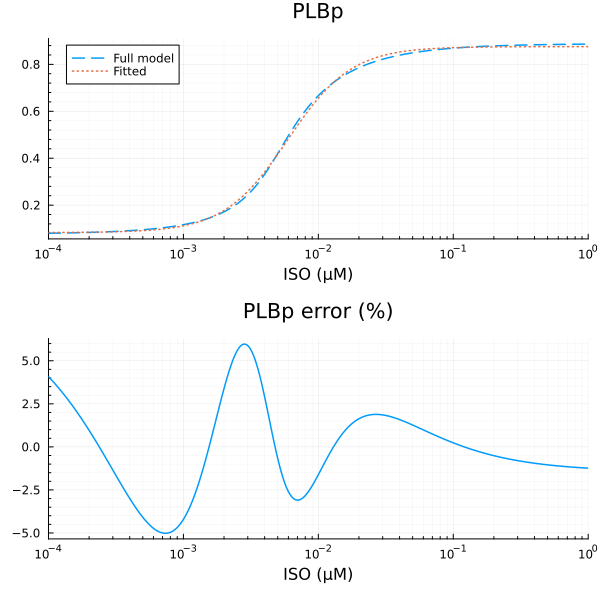

In [21]:
ypred = model_plb.(xdata, Ref(pestim))
p1 = plot(xdata, [ydata ypred], lab=["Full model" "Fitted"], line=[:dash :dot], title="PLBp", legend=:topleft; xopts...)
p2 = plot(xdata, (ypred .- ydata) ./ ydata .* 100; title="PLBp error (%)", lab=false, xopts...)
plot(p1, p2, layout=(2, 1), size=(600, 600))

## Fitting PLMp

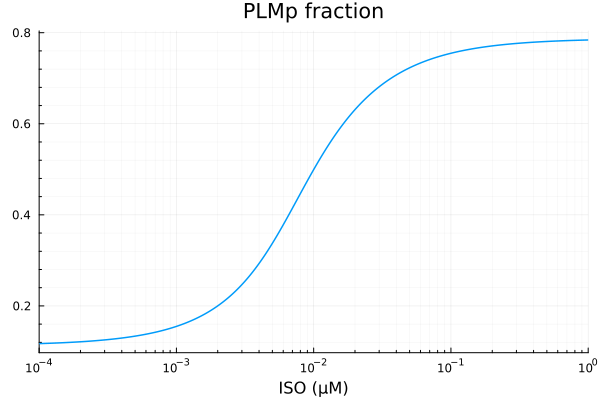

In [22]:
xdata = iso
ydata = extract(sim, sys.PLMp / sys.PLMtotBA)
plot(xdata, ydata, title="PLMp fraction", lab=false; xopts...)

In [23]:
@. model_plm(x, p) = p[1] * hil(x, p[2], p[3]) + p[4]
p0 = [0.8, 1e-2μM, 1.0, 0.1]
lb = [0.5, 1e-9μM, 1.0, 0.0]
fit = curve_fit(model_plm, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pestim = coef(fit)

4-element Vector{Float64}:
 0.6617189374539953
 0.008181715500075609
 1.3710342445443358
 0.11772727603832957

In [24]:
println("PLMp")
println("Basal activity: ", pestim[4])
println("Activated activity: ", pestim[1])
println("Michaelis constant: ", pestim[2], " μM")
println("Hill coefficient: ", pestim[3])
println("RMSE: ", rmse(fit))

PLMp
Basal activity: 0.11772727603832957
Activated activity: 0.6617189374539953
Michaelis constant: 0.008181715500075609 μM
Hill coefficient: 1.3710342445443358
RMSE: 0.003273838676778438


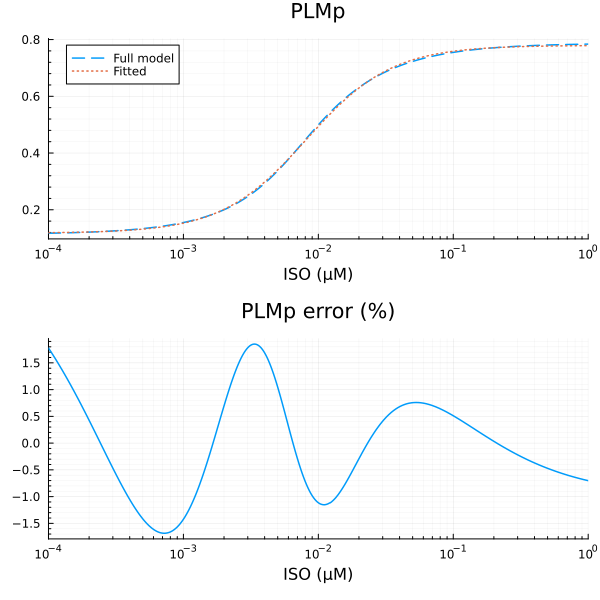

In [25]:
ypred = model_plm.(xdata, Ref(pestim))
p1 = plot(xdata, [ydata ypred], lab=["Full model" "Fitted"], line=[:dash :dot], title="PLMp", legend=:topleft; xopts...)
p2 = plot(xdata, (ypred .- ydata) ./ ydata .* 100; title="PLMp error (%)", lab=false, xopts...)
plot(p1, p2, layout=(2, 1), size=(600, 600))

## Fitting TnIp

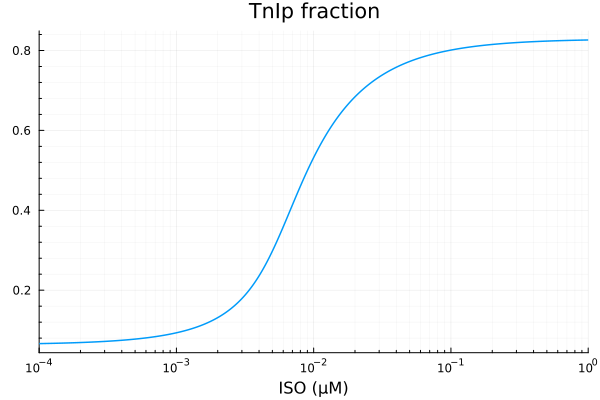

In [26]:
xdata = iso
ydata = extract(sim, sys.TnIp / sys.TnItotBA)
plot(xdata, ydata, title="TnIp fraction", lab=false; xopts...)

In [27]:
@. model_tni(x, p) = p[1] * hil(x, p[2], p[3]) + p[4]
p0 = [0.8, 1e-2μM, 1.0, 0.1]
lb = [0.1, 1e-9μM, 1.0, 0.0]
fit = curve_fit(model_tni, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pestim = coef(fit)

4-element Vector{Float64}:
 0.7481954981262161
 0.007856342545580718
 1.6973358042869
 0.06752961853123106

In [28]:
println("TnIp")
println("Basal activity: ", pestim[4])
println("Activated activity: ", pestim[1])
println("Michaelis constant: ", pestim[2], " μM")
println("Hill coefficient: ", pestim[3])
println("RMSE: ", rmse(fit))

TnIp
Basal activity: 0.06752961853123106
Activated activity: 0.7481954981262161
Michaelis constant: 0.007856342545580718 μM
Hill coefficient: 1.6973358042869
RMSE: 0.007437121115766605


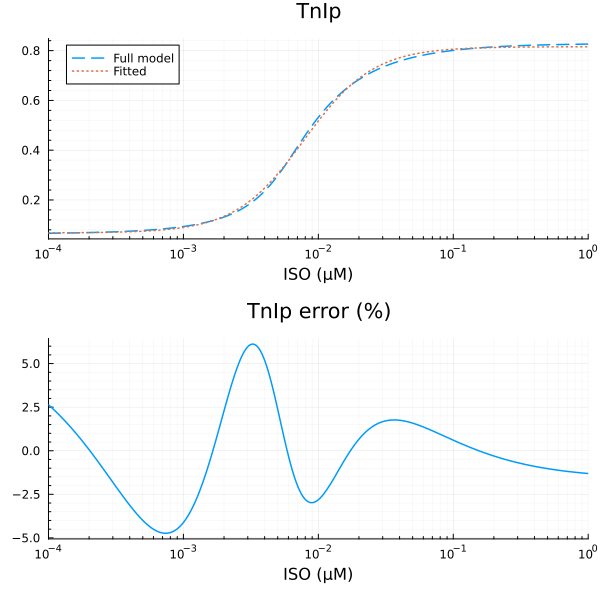

In [29]:
ypred = model_tni.(xdata, Ref(pestim))
p1 = plot(xdata, [ydata ypred], lab=["Full model" "Fitted"], line=[:dash :dot], title="TnIp", legend=:topleft; xopts...)
p2 = plot(xdata, (ypred .- ydata) ./ ydata .* 100; title="TnIp error (%)", lab=false, xopts...)
plot(p1, p2, layout=(2, 1), size=(600, 600))

## Fitting LCCap

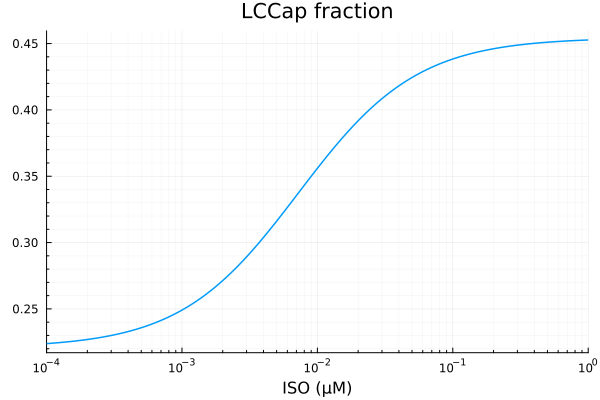

In [30]:
xdata = iso
ydata = extract(sim, sys.LCCap / sys.LCCtotBA)
plot(xdata, ydata, title="LCCap fraction", lab=false; xopts...)

In [31]:
@. model_lcc(x, p) = p[1] * hil(x, p[2]) + p[3]
p0 = [0.8, 1e-2μM, 0.1]
lb = [0.1, 1e-9μM, 0.0]
fit = curve_fit(model_lcc, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pestim = coef(fit)

3-element Vector{Float64}:
 0.23338200578128387
 0.007263357258342696
 0.2208194931437567

In [32]:
println("LCCap")
println("Basal activity: ", pestim[3])
println("Activated activity: ", pestim[1])
println("Michaelis constant: ", pestim[2], " μM")
println("RMSE: ", rmse(fit))

LCCap
Basal activity: 0.2208194931437567
Activated activity: 0.23338200578128387
Michaelis constant: 0.007263357258342696 μM
RMSE: 0.0001347238356812495


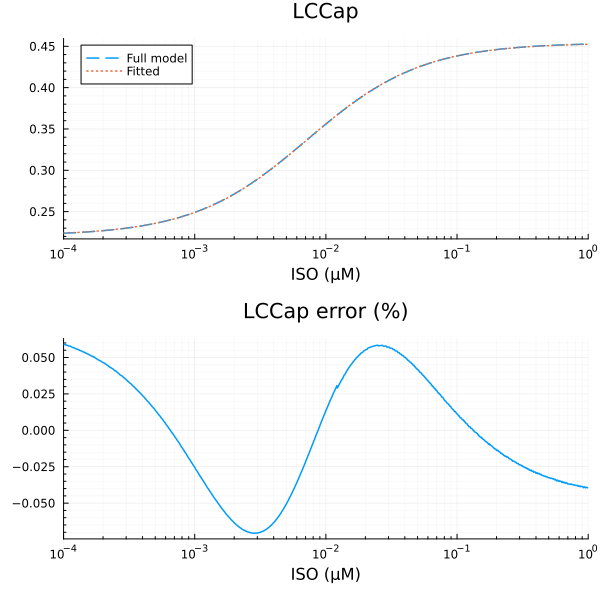

In [33]:
ypred = model_lcc.(xdata, Ref(pestim))
p1 = plot(xdata, [ydata ypred], lab=["Full model" "Fitted"], line=[:dash :dot], title="LCCap", legend=:topleft; xopts...)
p2 = plot(xdata, (ypred .- ydata) ./ ydata .* 100; title="LCCap error (%)", lab=false, xopts...)
plot(p1, p2, layout=(2, 1), size=(600, 600))

## Fitting LCCbp

In [34]:
xdata = iso
ydata = extract(sim, sys.LCCbp / sys.LCCtotBA)
plot(xdata, ydata, title="LCCbp fraction", lab=false; xopts...)

In [35]:
p0 = [0.8, 1e-2μM, 0.1]
lb = [0.1, 1e-9μM, 0.0]
fit = curve_fit(model_lcc, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pestim = coef(fit)

3-element Vector{Float64}:
 0.24558899924906163
 0.006961132215228242
 0.25200802323074334

In [36]:
println("LCCbp")
println("Basal activity: ", pestim[3])
println("Activated activity: ", pestim[1])
println("Michaelis constant: ", pestim[2], " μM")
println("RMSE: ", rmse(fit))

LCCbp
Basal activity: 0.25200802323074334
Activated activity: 0.24558899924906163
Michaelis constant: 0.006961132215228242 μM
RMSE: 0.00013805758907275832


In [37]:
ypred = model_lcc.(xdata, Ref(pestim))
p1 = plot(xdata, [ydata ypred], lab=["Full model" "Fitted"], line=[:dash :dot], title="LCCbp", legend=:topleft; xopts...)
p2 = plot(xdata, (ypred .- ydata) ./ ydata .* 100; title="LCCbp error (%)", lab=false, xopts...)
plot(p1, p2, layout=(2, 1), size=(600, 600))

## Fitting KURp

In [38]:
xdata = iso
ydata = extract(sim, sys.KURp / sys.IKurtotBA)
plot(xdata, ydata, title="LCCbp fraction", lab=false; xopts...)

In [39]:
@. model_kur(x, p) = p[1] * hil(x, p[2]) + p[3]
p0 = [0.8, 1e-2μM, 0.1]
lb = [0.1, 1e-9μM, 0.0]
fit = curve_fit(model_kur, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pestim = coef(fit)

3-element Vector{Float64}:
 0.2556572071975255
 0.005578161616313779
 0.4393640567201968

In [40]:
println("KURp")
println("Basal activity: ", pestim[3])
println("Activated activity: ", pestim[1])
println("Michaelis constant: ", pestim[2], " μM")
println("RMSE: ", rmse(fit))

KURp
Basal activity: 0.4393640567201968
Activated activity: 0.2556572071975255
Michaelis constant: 0.005578161616313779 μM
RMSE: 0.000148484283921716


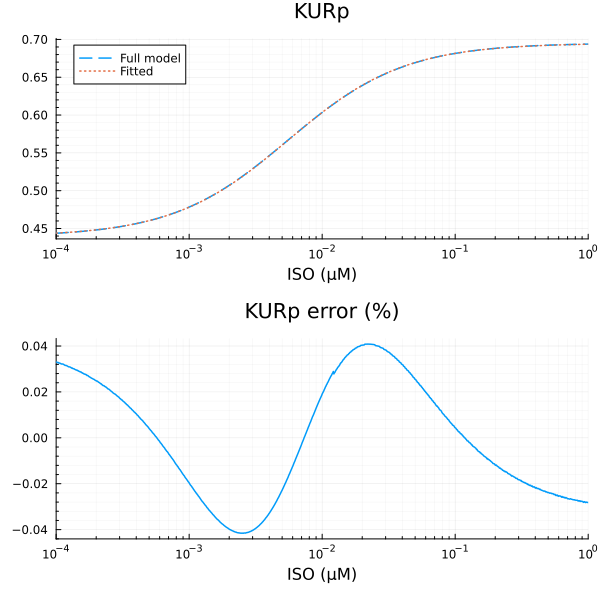

In [41]:
ypred = model_lcc.(xdata, Ref(pestim))
p1 = plot(xdata, [ydata ypred], lab=["Full model" "Fitted"], line=[:dash :dot], title="KURp", legend=:topleft; xopts...)
p2 = plot(xdata, (ypred .- ydata) ./ ydata .* 100; title="KURp error (%)", lab=false, xopts...)
plot(p1, p2, layout=(2, 1), size=(600, 600))

## Fitting RyRp

In [42]:
xdata = iso
ydata = extract(sim, sys.RyR_PKAp)
plot(xdata, ydata, title="RyRp fraction", lab=false; xopts...)

In [43]:
@. model(x, p) = p[1] * x / (x + p[2]) + p[3]
p0 = [0.3, 1e-2μM, 0.1]
lb = [0.0, 1e-9μM, 0.0]
fit = curve_fit(model, xdata, ydata, p0; lower=lb, autodiff=:forwarddiff)
pestim = coef(fit)

3-element Vector{Float64}:
 0.23988668426667809
 0.00750987813984036
 0.20539807148749487

In [44]:
println("RyRp")
println("Basal activity: ", pestim[3])
println("Activated activity: ", pestim[1])
println("Michaelis constant: ", pestim[2], " μM")
println("RMSE: ", rmse(fit))

RyRp
Basal activity: 0.20539807148749487
Activated activity: 0.23988668426667809
Michaelis constant: 0.00750987813984036 μM
RMSE: 7.686608055144195e-5


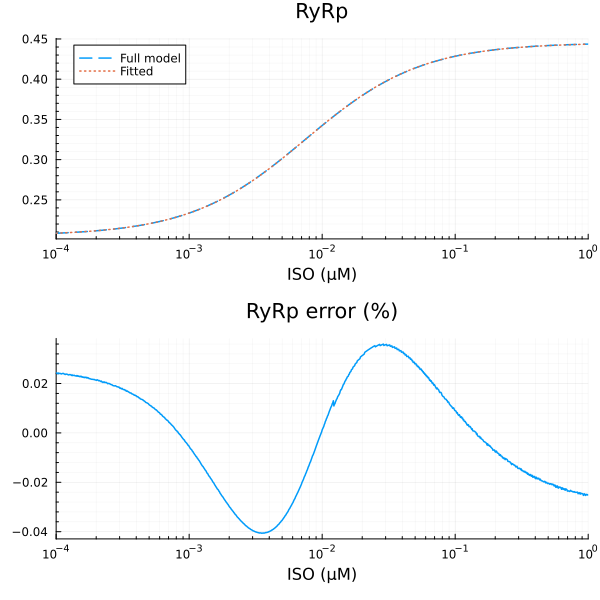

In [45]:
ypred = model.(xdata, Ref(pestim))
p1 = plot(xdata, [ydata ypred], lab=["Full model" "Fitted"], line=[:dash :dot], title="RyRp", legend=:topleft; xopts...)
p2 = plot(xdata, (ypred .- ydata) ./ ydata .* 100; title="RyRp error (%)", lab=false, xopts...)
plot(p1, p2, layout=(2, 1), size=(600, 600))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*